# Results and Discussions

Merlion is a comprehensive Machine Learning library which aggregates multiple features from different existing packages for Time Series Analysis. Its own DefaultForecaster model is simple to use but provides robust results with seasonality detection and hyperparameter tuning are built into the the model. 

The authors used this forecaster as a benchmark to predict the impact that media tone has on several company stocks. Through webscraping, the team aggregated the closing stock prices of several companies such as Tesla, Facebook, Netflix, and Amazon. The aggregated media tone in the form of its average and cumulutive sum were added as a feature for forecasting the stock's closing price for each company. Each dataset was split into a 80% Train and 20% Test set which the forecaster generated predictions for. Predictions for each company's stock was generated in 1, 3, and 5 day sliding windows with the last value of each window being used as the predicted value as a trading strategy. 

Mean Average Error was used to company the actual historical values with the model's predicted values for ease of interpretability.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

from merlion.utils import TimeSeries
from merlion.utils.time_series import TimeSeries

from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig
from merlion.models.factory import ModelFactory

from merlion.evaluate.forecast import ForecastMetric, ForecastEvaluator, ForecastEvaluatorConfig

In [2]:
warnings.filterwarnings("ignore")

# Filepaths

In [108]:
tesla_path = '~/cpt1/bdcc/final_project/GDELTS/tesla_complete.csv'
teslasum_path = '~/cpt1/bdcc/final_project/GDELTS/tesla_cumsum_completed.csv'
fb_path = '~/cpt1/bdcc/final_project/GDELTS/facebook_completed.csv'
fbsum_path = '~/cpt1/bdcc/final_project/GDELTS/facebook_cumsum_completed.csv'
n_path = '~/cpt1/bdcc/final_project/GDELTS/netflix_completed.csv'
nsum_path = '~/cpt1/bdcc/final_project/GDELTS/netflix_cumsum_completed.csv'
amz_path = '~/cpt1/bdcc/final_project/GDELTS/amazon_completed.csv'
amzsum_path = '~/cpt1/bdcc/final_project/GDELTS/amazon_cumsum_completed.csv'

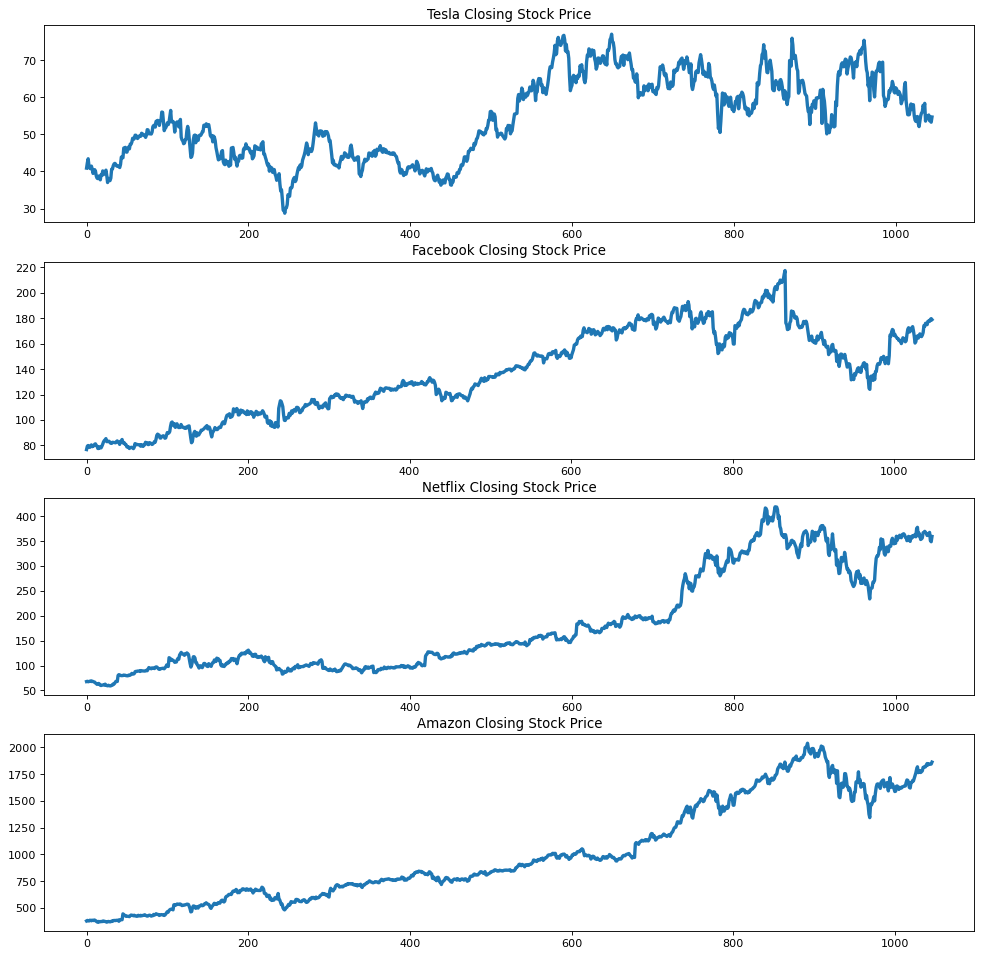

In [112]:
tesla_eda = pd.read_csv(tesla_path)
fb_eda = pd.read_csv(fb_path)
n_eda = pd.read_csv(n_path)
amz_eda = pd.read_csv(amz_path)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15, 15), dpi=80)

ax1.plot(tesla_df['Close'], linewidth=3, label='Tesla')
ax1.set_title('Tesla Closing Stock Price')

ax2.plot(fb_eda['Close'], linewidth=3, label='Facebook')
ax2.set_title('Facebook Closing Stock Price')

ax3.plot(n_eda['Close'], linewidth=3, label='Netflix')
ax3.set_title('Netflix Closing Stock Price')

ax4.plot(amz_eda['Close'], linewidth=3, label='Amazon')
ax4.set_title('Amazon Closing Stock Price');

In [73]:
def forecaster(input_dict):
    
    # Pull parameters from dictionary
    fpath = input_dict['fpath']
    stock_name = input_dict['stock_name']
    run_name = input_dict['run_name']
    tone = input_dict['tone']
    test_size = input_dict['test_size']
    steps = input_dict['steps']
    horizon = input_dict['horizon']
    
    # Process Dataset
    df = pd.read_csv(fpath)
    df_mv = df.copy()
    df_mv['Date'] = pd.date_range(df['Date'][0], periods=df.shape[0], freq='D')
    df_mv.set_index('Date', inplace=True)

    # Incorporate Tone
    if tone:
        df_mv = df_mv[['Close', 'Daily Average Tone']]
        scaler = StandardScaler()
        scaler.fit(df_mv[['Daily Average Tone']][-210:])
        df_mv['Daily Average Tone'] = (scaler.transform(df_mv[['Daily Average Tone']]))

    else:
        df_mv = df_mv[['Close']]

    # Train Test Split
    train_data = TimeSeries.from_pd(df_mv[:-test_size])
    test_data  = TimeSeries.from_pd(df_mv[-test_size:])

    # Load Model
    target_seq_index = 0
    max_forecast_steps = steps
    kwargs = dict(target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps)

    model1 = ModelFactory.create("DefaultForecaster", **kwargs)
    model2 = ModelFactory.create("Arima", **kwargs)

    # Evaluate MAE
    results = []
    for model in [model1, model2]:
        evaluator = ForecastEvaluator(model=model, config=ForecastEvaluatorConfig(
            horizon=horizon, cadence="1d", retrain_freq=None))
        train_result, test_pred = evaluator.get_predict(train_vals=train_data, test_vals=test_data)
        mae = evaluator.evaluate(ground_truth=test_data, predict=test_pred, metric=ForecastMetric.MAE)
        results.append([stock_name, 
                        run_name,
                        horizon,
                        type(model).__name__, 
                        mae])
        
    evaluator = ForecastEvaluator(model=model1, config=ForecastEvaluatorConfig(horizon=horizon, cadence="1d", retrain_freq=None))
    train_result, test_pred = evaluator.get_predict(train_vals=train_data, test_vals=test_data)
    mae = evaluator.evaluate(ground_truth=test_data, predict=test_pred, metric=ForecastMetric.MAE)

    real_date = df[-test_size:].copy()
    real_date = real_date.reset_index()

    # Extract Prediction Data
    if horizon != '1d':
        pred_data = df_mv[-test_size:]
        pred_data.reset_index(inplace=True, drop=True)
        pred_data['Date'] = real_date['Date']

        pred_list = []
        for i in test_pred:
            pred_list.append(pd.Series(list(i)))

        for i in range(test_size):
            pred_data.loc[pred_data.index[i], 'Pred'] = pred_list[i][(len(pred_list[i])-1)][1][0]

    else:
        pred_data = pd.DataFrame(test_pred.univariates['Close'])
        pred_data = pred_data[~pred_data.index.duplicated(keep='last')]
        pred_data.reset_index(drop=True, inplace=True)
        pred_data['Date'] = real_date['Date']
        pred_data['Pred'] = pred_data['Close']
        pred_data['Close'] = real_date['Close'] 
        
    return [results, pred_data, mae]

# Tesla

In [82]:
tesla_only1d_dict = {'fpath': tesla_path, 'stock_name': 'Tesla', 'run_name': 'None', 'tone': False, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
tesla_ave1d_dict = {'fpath': tesla_path, 'stock_name': 'Tesla', 'run_name': 'Average', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
tesla_cumsum1d_dict = {'fpath': teslasum_path, 'stock_name': 'Tesla', 'run_name': 'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}

tesla_only3d_dict = {'fpath': tesla_path, 'stock_name': 'Tesla', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
tesla_ave3d_dict = {'fpath': tesla_path, 'stock_name': 'Tesla', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
tesla_cumsum3d_dict = {'fpath': teslasum_path, 'stock_name': 'Tesla', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}

tesla_only5d_dict = {'fpath': tesla_path, 'stock_name': 'Tesla', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
tesla_ave5d_dict = {'fpath': tesla_path, 'stock_name': 'Tesla', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
tesla_cumsum5d_dict = {'fpath': teslasum_path, 'stock_name': 'Tesla', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}

In [83]:
tesla_only1d = forecaster(tesla_only1d_dict)
tesla_ave1d = forecaster(tesla_ave1d_dict)
tesla_cumsum1d = forecaster(tesla_cumsum1d_dict)

tesla_only3d = forecaster(tesla_only3d_dict)
tesla_ave3d = forecaster(tesla_ave3d_dict)
tesla_cumsum3d = forecaster(tesla_cumsum3d_dict)

tesla_only5d = forecaster(tesla_only5d_dict)
tesla_ave5d = forecaster(tesla_ave5d_dict)
tesla_cumsum5d = forecaster(tesla_cumsum5d_dict)

ForecastEvaluator: 100%|██████████| 18057600/18057600 [01:06<00:00, 273201.21it/s]


In [107]:
tesla_only1d
tesla_ave1d
tesla_cumsum1d

tesla_only3d
tesla_ave3d
tesla_cumsum3d

tesla_only5d
tesla_ave5d
tesla_cumsum5d

[['Tesla', 'None', '1d', 'DefaultForecaster', 2.9483849484112965],
 ['Tesla', 'None', '1d', 'Arima', 2.3713438775583047]]

In [84]:
tesla_df = pd.read_csv(tesla_path)
actual = tesla_df['Close'].copy()
test_size = 210

tesla_only1d_data = tesla_only1d[1][['Pred']].copy()
tesla_ave1d_data = tesla_ave1d[1][['Pred']].copy()
tesla_cumsum1d_data = tesla_cumsum1d[1][['Pred']].copy()
tesla_only1d_data = tesla_only1d_data.set_index(actual[-test_size:].index)
tesla_ave1d_data = tesla_ave1d_data.set_index(actual[-test_size:].index)
tesla_cumsum1d_data = tesla_cumsum1d_data.set_index(actual[-test_size:].index)

tesla_only3d_data = tesla_only3d[1][['Pred']].copy()
tesla_ave3d_data = tesla_ave3d[1][['Pred']].copy()
tesla_cumsum3d_data = tesla_cumsum3d[1][['Pred']].copy()

tesla_only3d_data = tesla_only3d_data.set_index(actual[-test_size:].index)
tesla_ave3d_data = tesla_ave3d_data.set_index(actual[-test_size:].index)
tesla_cumsum3d_data = tesla_cumsum3d_data.set_index(actual[-test_size:].index)

tesla_only5d_data = tesla_only5d[1][['Pred']].copy()
tesla_ave5d_data = tesla_ave5d[1][['Pred']].copy()
tesla_cumsum5d_data = tesla_cumsum5d[1][['Pred']].copy()

tesla_only5d_data = tesla_only5d_data.set_index(actual[-test_size:].index)
tesla_ave5d_data = tesla_ave5d_data.set_index(actual[-test_size:].index)
tesla_cumsum5d_data = tesla_cumsum5d_data.set_index(actual[-test_size:].index)

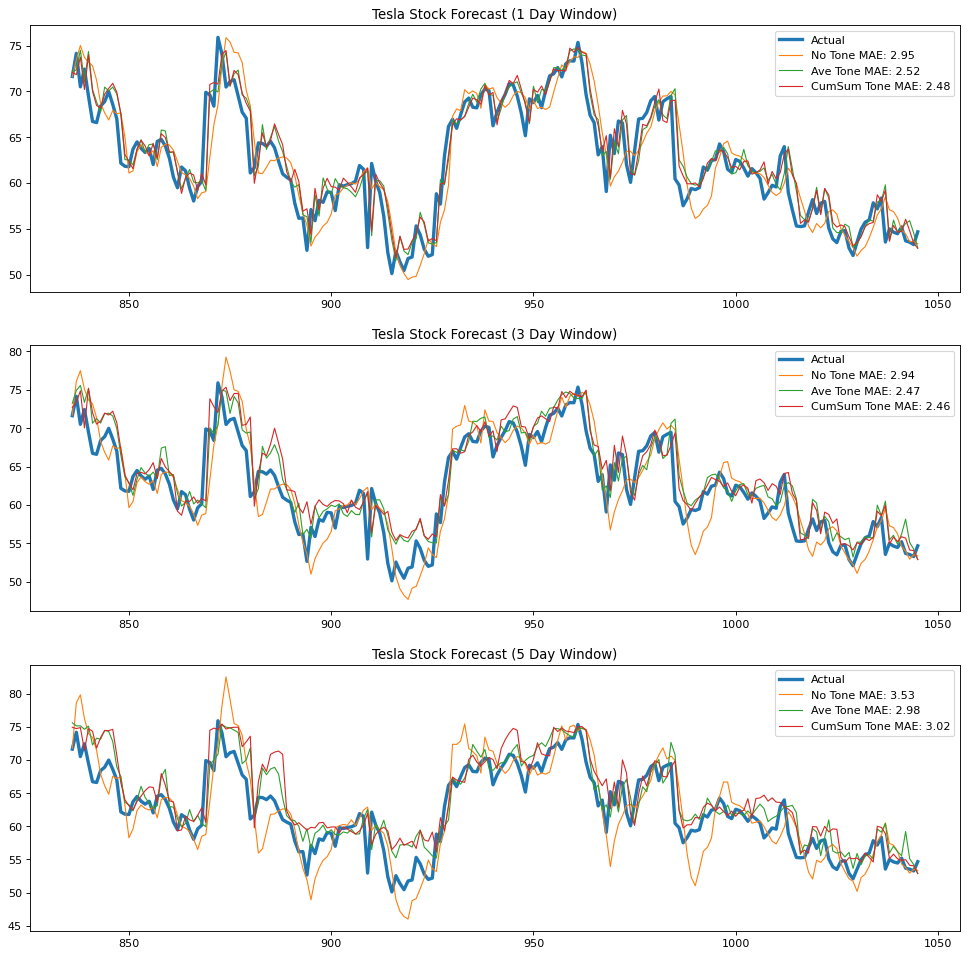

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15), dpi=80)

ax1.plot(tesla_df['Close'][-test_size:], linewidth=3, label='Actual')
ax1.plot(tesla_only1d_data, linewidth=1, label=f'No Tone MAE: {tesla_only1d[2]:.2f}')
ax1.plot(tesla_ave1d_data, linewidth=1, label=f'Ave Tone MAE: {tesla_ave1d[2]:.2f}')
ax1.plot(tesla_cumsum1d_data, linewidth=1, label=f'CumSum Tone MAE: {tesla_cumsum1d[2]:.2f}')
ax1.set_title('Tesla Stock Forecast (1 Day Window)')
ax1.legend()

ax2.plot(tesla_df['Close'][-test_size:], linewidth=3, label='Actual')
ax2.plot(tesla_only3d_data, linewidth=1, label=f'No Tone MAE: {tesla_only3d[2]:.2f}')
ax2.plot(tesla_ave3d_data, linewidth=1, label=f'Ave Tone MAE: {tesla_ave3d[2]:.2f}')
ax2.plot(tesla_cumsum3d_data, linewidth=1, label=f'CumSum Tone MAE: {tesla_cumsum3d[2]:.2f}')
ax2.set_title('Tesla Stock Forecast (3 Day Window)')
ax2.legend()

ax3.plot(tesla_df['Close'][-test_size:], linewidth=3, label='Actual')
ax3.plot(tesla_only5d_data, linewidth=1, label=f'No Tone MAE: {tesla_only5d[2]:.2f}')
ax3.plot(tesla_ave5d_data, linewidth=1, label=f'Ave Tone MAE: {tesla_ave5d[2]:.2f}')
ax3.plot(tesla_cumsum5d_data, linewidth=1, label=f'CumSum Tone MAE: {tesla_cumsum5d[2]:.2f}')
ax3.set_title('Tesla Stock Forecast (5 Day Window)')
ax3.legend();

# Facebook

In [86]:
fb_only1d_dict = {'fpath': fb_path, 'stock_name': 'Facebook', 'run_name': 'None', 'tone': False, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
fb_ave1d_dict = {'fpath': fb_path, 'stock_name': 'Facebook', 'run_name': 'Average', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
fb_cumsum1d_dict = {'fpath': fbsum_path, 'stock_name': 'Facebook', 'run_name': 'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}

fb_only3d_dict = {'fpath': fb_path, 'stock_name': 'Facebook', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
fb_ave3d_dict = {'fpath': fb_path, 'stock_name': 'Facebook', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
fb_cumsum3d_dict = {'fpath': fbsum_path, 'stock_name': 'Facebook', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}

fb_only5d_dict = {'fpath': fb_path, 'stock_name': 'Facebook', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
fb_ave5d_dict = {'fpath': fb_path, 'stock_name': 'Facebook', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
fb_cumsum5d_dict = {'fpath': fbsum_path, 'stock_name': 'Facebook', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}

In [88]:
fb_only1d = forecaster(fb_only1d_dict)
fb_ave1d = forecaster(fb_ave1d_dict)
fb_cumsum1d = forecaster(fb_cumsum1d_dict)

fb_only3d = forecaster(fb_only3d_dict)
fb_ave3d = forecaster(fb_ave3d_dict)
fb_cumsum3d = forecaster(fb_cumsum3d_dict)

fb_only5d = forecaster(fb_only5d_dict)
fb_ave5d = forecaster(fb_ave5d_dict)
fb_cumsum5d = forecaster(fb_cumsum5d_dict)

ForecastEvaluator: 100%|██████████| 18057600/18057600 [01:08<00:00, 264028.78it/s]


In [89]:
fb_df = pd.read_csv(fb_path)
actual = fb_df['Close'].copy()
test_size = 210

fb_only1d_data = fb_only1d[1][['Pred']].copy()
fb_ave1d_data = fb_ave1d[1][['Pred']].copy()
fb_cumsum1d_data = fb_cumsum1d[1][['Pred']].copy()
fb_only1d_data = fb_only1d_data.set_index(actual[-test_size:].index)
fb_ave1d_data = fb_ave1d_data.set_index(actual[-test_size:].index)
fb_cumsum1d_data = fb_cumsum1d_data.set_index(actual[-test_size:].index)

fb_only3d_data = fb_only3d[1][['Pred']].copy()
fb_ave3d_data = fb_ave3d[1][['Pred']].copy()
fb_cumsum3d_data = fb_cumsum3d[1][['Pred']].copy()

fb_only3d_data = fb_only3d_data.set_index(actual[-test_size:].index)
fb_ave3d_data = fb_ave3d_data.set_index(actual[-test_size:].index)
fb_cumsum3d_data = fb_cumsum3d_data.set_index(actual[-test_size:].index)

fb_only5d_data = fb_only5d[1][['Pred']].copy()
fb_ave5d_data = fb_ave5d[1][['Pred']].copy()
fb_cumsum5d_data = fb_cumsum5d[1][['Pred']].copy()

fb_only5d_data = fb_only5d_data.set_index(actual[-test_size:].index)
fb_ave5d_data = fb_ave5d_data.set_index(actual[-test_size:].index)
fb_cumsum5d_data = fb_cumsum5d_data.set_index(actual[-test_size:].index)

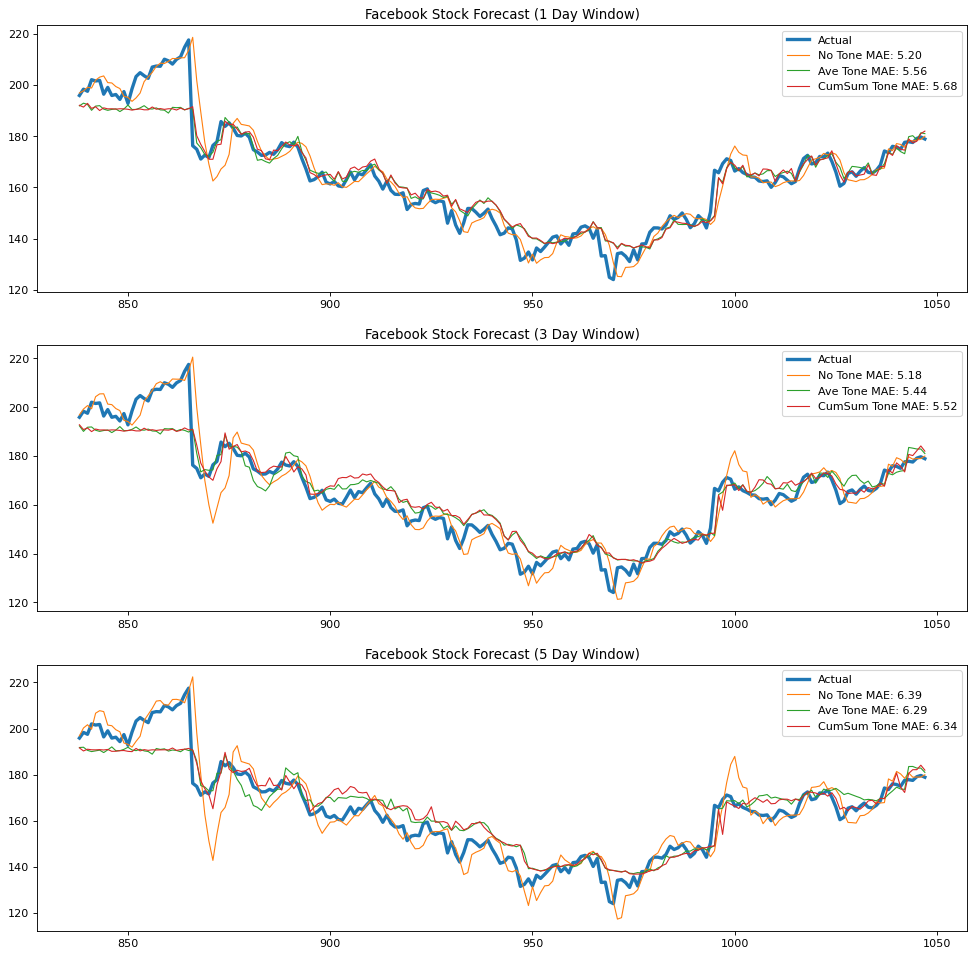

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15), dpi=80)

ax1.plot(fb_df['Close'][-test_size:], linewidth=3, label='Actual')
ax1.plot(fb_only1d_data, linewidth=1, label=f'No Tone MAE: {fb_only1d[2]:.2f}')
ax1.plot(fb_ave1d_data, linewidth=1, label=f'Ave Tone MAE: {fb_ave1d[2]:.2f}')
ax1.plot(fb_cumsum1d_data, linewidth=1, label=f'CumSum Tone MAE: {fb_cumsum1d[2]:.2f}')
ax1.set_title('Facebook Stock Forecast (1 Day Window)')
ax1.legend()

ax2.plot(fb_df['Close'][-test_size:], linewidth=3, label='Actual')
ax2.plot(fb_only3d_data, linewidth=1, label=f'No Tone MAE: {fb_only3d[2]:.2f}')
ax2.plot(fb_ave3d_data, linewidth=1, label=f'Ave Tone MAE: {fb_ave3d[2]:.2f}')
ax2.plot(fb_cumsum3d_data, linewidth=1, label=f'CumSum Tone MAE: {fb_cumsum3d[2]:.2f}')
ax2.set_title('Facebook Stock Forecast (3 Day Window)')
ax2.legend()

ax3.plot(fb_df['Close'][-test_size:], linewidth=3, label='Actual')
ax3.plot(fb_only5d_data, linewidth=1, label=f'No Tone MAE: {fb_only5d[2]:.2f}')
ax3.plot(fb_ave5d_data, linewidth=1, label=f'Ave Tone MAE: {fb_ave5d[2]:.2f}')
ax3.plot(fb_cumsum5d_data, linewidth=1, label=f'CumSum Tone MAE: {fb_cumsum5d[2]:.2f}')
ax3.set_title('Facebook Stock Forecast (5 Day Window)')
ax3.legend();

In [91]:
n_only1d_dict = {'fpath': n_path, 'stock_name': 'Netflix', 'run_name': 'None', 'tone': False, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
n_ave1d_dict = {'fpath': n_path, 'stock_name': 'Netflix', 'run_name': 'Average', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
n_cumsum1d_dict = {'fpath': nsum_path, 'stock_name': 'Netflix', 'run_name': 'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}

n_only3d_dict = {'fpath': n_path, 'stock_name': 'Netflix', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
n_ave3d_dict = {'fpath': n_path, 'stock_name': 'Netflix', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
n_cumsum3d_dict = {'fpath': nsum_path, 'stock_name': 'Netflix', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}

n_only5d_dict = {'fpath': n_path, 'stock_name': 'Netflix', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
n_ave5d_dict = {'fpath': n_path, 'stock_name': 'Netflix', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
n_cumsum5d_dict = {'fpath': nsum_path, 'stock_name': 'Netflix', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}

In [93]:
n_only1d = forecaster(n_only1d_dict)
n_ave1d = forecaster(n_ave1d_dict)
n_cumsum1d = forecaster(n_cumsum1d_dict)

n_only3d = forecaster(n_only3d_dict)
n_ave3d = forecaster(n_ave3d_dict)
n_cumsum3d = forecaster(n_cumsum3d_dict)

n_only5d = forecaster(n_only5d_dict)
n_ave5d = forecaster(n_ave5d_dict)
n_cumsum5d = forecaster(n_cumsum5d_dict)

ForecastEvaluator: 100%|██████████| 18057600/18057600 [01:23<00:00, 216686.50it/s]


In [94]:
n_df = pd.read_csv(n_path)
actual = n_df['Close'].copy()
test_size = 210

n_only1d_data = n_only1d[1][['Pred']].copy()
n_ave1d_data = n_ave1d[1][['Pred']].copy()
n_cumsum1d_data = n_cumsum1d[1][['Pred']].copy()
n_only1d_data = n_only1d_data.set_index(actual[-test_size:].index)
n_ave1d_data = n_ave1d_data.set_index(actual[-test_size:].index)
n_cumsum1d_data = n_cumsum1d_data.set_index(actual[-test_size:].index)

n_only3d_data = n_only3d[1][['Pred']].copy()
n_ave3d_data = n_ave3d[1][['Pred']].copy()
n_cumsum3d_data = n_cumsum3d[1][['Pred']].copy()

n_only3d_data = n_only3d_data.set_index(actual[-test_size:].index)
n_ave3d_data = n_ave3d_data.set_index(actual[-test_size:].index)
n_cumsum3d_data = n_cumsum3d_data.set_index(actual[-test_size:].index)

n_only5d_data = n_only5d[1][['Pred']].copy()
n_ave5d_data = n_ave5d[1][['Pred']].copy()
n_cumsum5d_data = n_cumsum5d[1][['Pred']].copy()

n_only5d_data = n_only5d_data.set_index(actual[-test_size:].index)
n_ave5d_data = n_ave5d_data.set_index(actual[-test_size:].index)
n_cumsum5d_data = n_cumsum5d_data.set_index(actual[-test_size:].index)

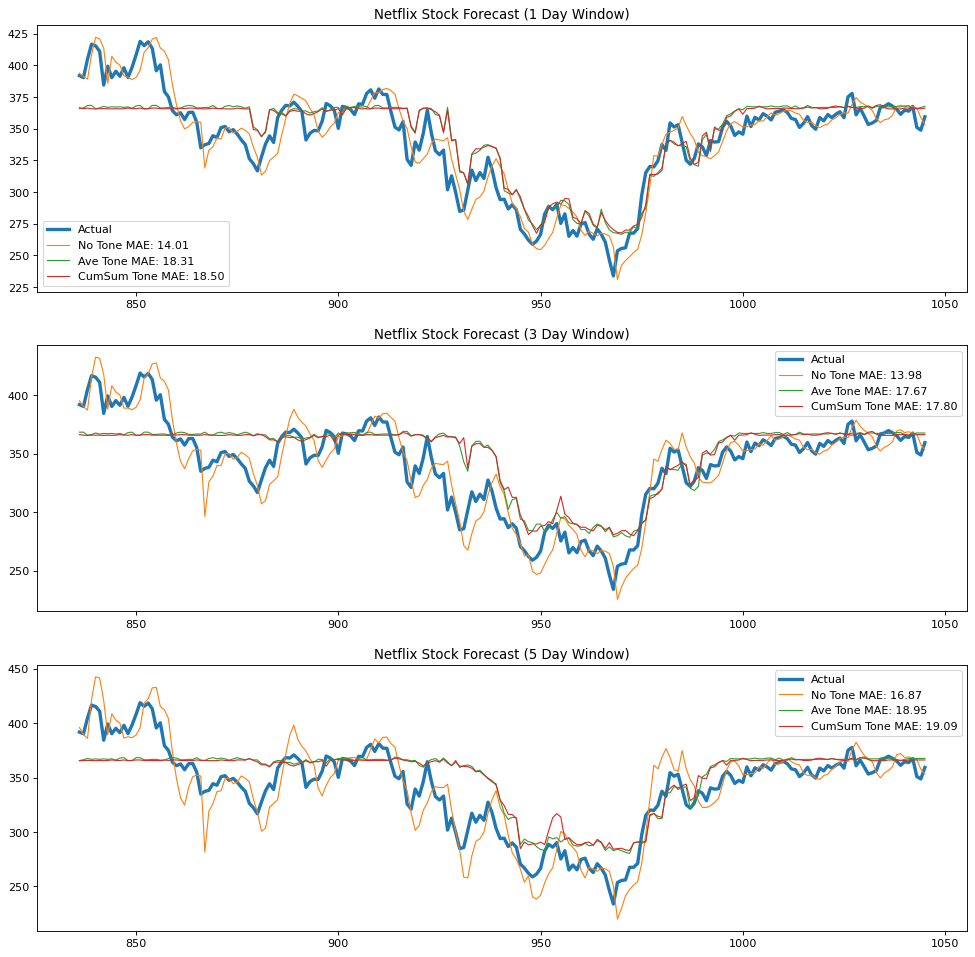

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15), dpi=80)

ax1.plot(n_df['Close'][-test_size:], linewidth=3, label='Actual')
ax1.plot(n_only1d_data, linewidth=1, label=f'No Tone MAE: {n_only1d[2]:.2f}')
ax1.plot(n_ave1d_data, linewidth=1, label=f'Ave Tone MAE: {n_ave1d[2]:.2f}')
ax1.plot(n_cumsum1d_data, linewidth=1, label=f'CumSum Tone MAE: {n_cumsum1d[2]:.2f}')
ax1.set_title('Netflix Stock Forecast (1 Day Window)')
ax1.legend()

ax2.plot(n_df['Close'][-test_size:], linewidth=3, label='Actual')
ax2.plot(n_only3d_data, linewidth=1, label=f'No Tone MAE: {n_only3d[2]:.2f}')
ax2.plot(n_ave3d_data, linewidth=1, label=f'Ave Tone MAE: {n_ave3d[2]:.2f}')
ax2.plot(n_cumsum3d_data, linewidth=1, label=f'CumSum Tone MAE: {n_cumsum3d[2]:.2f}')
ax2.set_title('Netflix Stock Forecast (3 Day Window)')
ax2.legend()

ax3.plot(n_df['Close'][-test_size:], linewidth=3, label='Actual')
ax3.plot(n_only5d_data, linewidth=1, label=f'No Tone MAE: {n_only5d[2]:.2f}')
ax3.plot(n_ave5d_data, linewidth=1, label=f'Ave Tone MAE: {n_ave5d[2]:.2f}')
ax3.plot(n_cumsum5d_data, linewidth=1, label=f'CumSum Tone MAE: {n_cumsum5d[2]:.2f}')
ax3.set_title('Netflix Stock Forecast (5 Day Window)')
ax3.legend();

In [ ]:
tesla_path = '~/cpt1/bdcc/final_project/GDELTS/tesla_complete.csv'
teslasum_path = '~/cpt1/bdcc/final_project/GDELTS/tesla_cumsum_completed.csv'
fb_path = '~/cpt1/bdcc/final_project/GDELTS/facebook_completed.csv'
fbsum_path = '~/cpt1/bdcc/final_project/GDELTS/facebook_cumsum_completed.csv'
n_path = '~/cpt1/bdcc/final_project/GDELTS/netflix_completed.csv'
nsum_path = '~/cpt1/bdcc/final_project/GDELTS/netflix_cumsum_completed.csv'
amz_path = '~/cpt1/bdcc/final_project/GDELTS/amazon_completed.csv'
amzsum_path = '~/cpt1/bdcc/final_project/GDELTS/amazon_cumsum_completed.csv'

In [97]:
amz_only1d_dict = {'fpath': amz_path, 'stock_name': 'Amazon', 'run_name': 'None', 'tone': False, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
amz_ave1d_dict = {'fpath': amz_path, 'stock_name': 'Amazon', 'run_name': 'Average', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}
amz_cumsum1d_dict = {'fpath': amzsum_path, 'stock_name': 'Amazon', 'run_name': 'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 210, 'horizon': '1d'}

amz_only3d_dict = {'fpath': amz_path, 'stock_name': 'Amazon', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
amz_ave3d_dict = {'fpath': amz_path, 'stock_name': 'Amazon', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}
amz_cumsum3d_dict = {'fpath': amzsum_path, 'stock_name': 'Amazon', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 70, 'horizon': '3d'}

amz_only5d_dict = {'fpath': amz_path, 'stock_name': 'Amazon', 'run_name':'None', 'tone': False, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
amz_ave5d_dict = {'fpath': amz_path, 'stock_name': 'Amazon', 'run_name':'Average', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}
amz_cumsum5d_dict = {'fpath': amzsum_path, 'stock_name': 'Amazon', 'run_name':'Cumulative Sum', 'tone': True, 'test_size': 210, 'steps': 42, 'horizon': '5d'}

In [98]:
amz_only1d = forecaster(amz_only1d_dict)
amz_ave1d = forecaster(amz_ave1d_dict)
amz_cumsum1d = forecaster(amz_cumsum1d_dict)

amz_only3d = forecaster(amz_only3d_dict)
amz_ave3d = forecaster(amz_ave3d_dict)
amz_cumsum3d = forecaster(amz_cumsum3d_dict)

amz_only5d = forecaster(amz_only5d_dict)
amz_ave5d = forecaster(amz_ave5d_dict)
amz_cumsum5d = forecaster(amz_cumsum5d_dict)

ForecastEvaluator: 100%|██████████| 18057600/18057600 [01:08<00:00, 264008.07it/s]


In [103]:
amz_df = pd.read_csv(amz_path)
actual = amz_df['Close'].copy()
test_size = 210

amz_only1d_data = amz_only1d[1][['Pred']].copy()
amz_ave1d_data = amz_ave1d[1][['Pred']].copy()
amz_cumsum1d_data = amz_cumsum1d[1][['Pred']].copy()
amz_only1d_data = amz_only1d_data.set_index(actual[-test_size:].index)
amz_ave1d_data = amz_ave1d_data.set_index(actual[-test_size:].index)
amz_cumsum1d_data = amz_cumsum1d_data.set_index(actual[-test_size:].index)

amz_only3d_data = amz_only3d[1][['Pred']].copy()
amz_ave3d_data = amz_ave3d[1][['Pred']].copy()
amz_cumsum3d_data = amz_cumsum3d[1][['Pred']].copy()

amz_only3d_data = amz_only3d_data.set_index(actual[-test_size:].index)
amz_ave3d_data = amz_ave3d_data.set_index(actual[-test_size:].index)
amz_cumsum3d_data = amz_cumsum3d_data.set_index(actual[-test_size:].index)

amz_only5d_data = amz_only5d[1][['Pred']].copy()
amz_ave5d_data = amz_ave5d[1][['Pred']].copy()
amz_cumsum5d_data = amz_cumsum5d[1][['Pred']].copy()

amz_only5d_data = amz_only5d_data.set_index(actual[-test_size:].index)
amz_ave5d_data = amz_ave5d_data.set_index(actual[-test_size:].index)
amz_cumsum5d_data = amz_cumsum5d_data.set_index(actual[-test_size:].index)

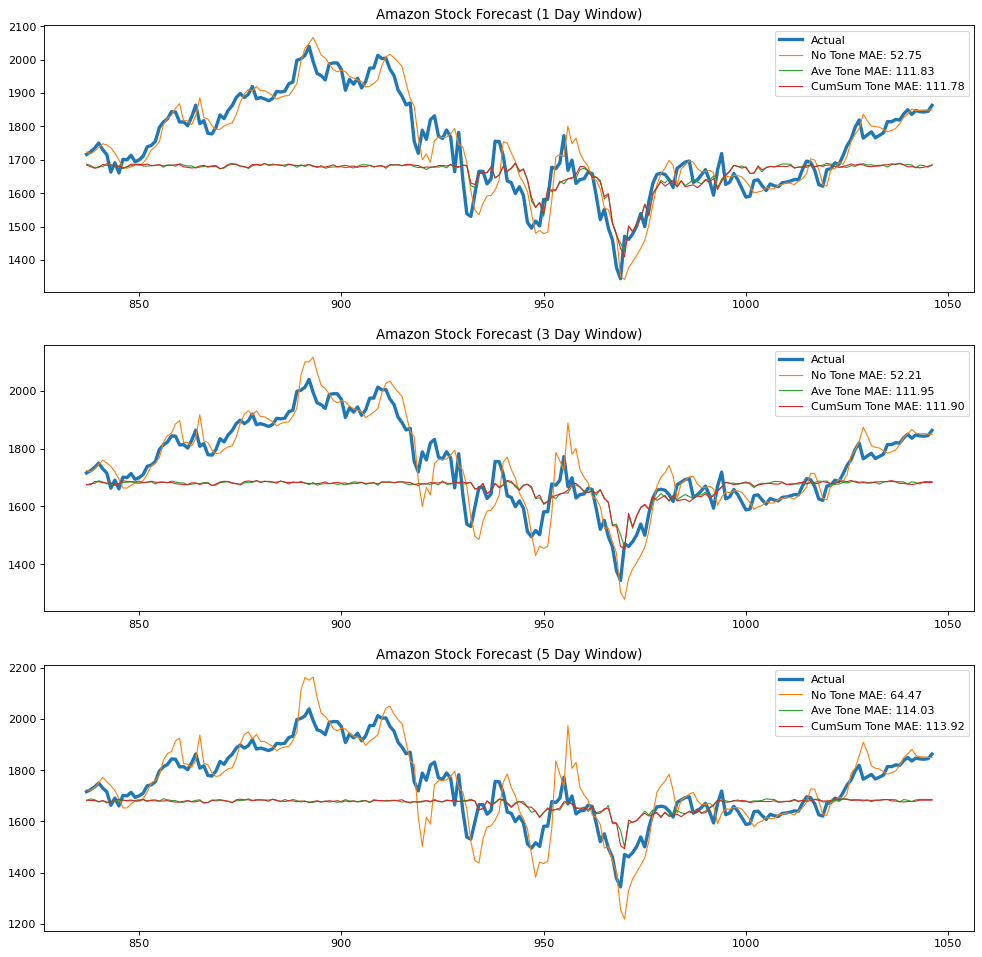

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15), dpi=80)

ax1.plot(amz_df['Close'][-test_size:], linewidth=3, label='Actual')
ax1.plot(amz_only1d_data, linewidth=1, label=f'No Tone MAE: {amz_only1d[2]:.2f}')
ax1.plot(amz_ave1d_data, linewidth=1, label=f'Ave Tone MAE: {amz_ave1d[2]:.2f}')
ax1.plot(amz_cumsum1d_data, linewidth=1, label=f'CumSum Tone MAE: {amz_cumsum1d[2]:.2f}')
ax1.set_title('Amazon Stock Forecast (1 Day Window)')
ax1.legend()

ax2.plot(amz_df['Close'][-test_size:], linewidth=3, label='Actual')
ax2.plot(amz_only3d_data, linewidth=1, label=f'No Tone MAE: {amz_only3d[2]:.2f}')
ax2.plot(amz_ave3d_data, linewidth=1, label=f'Ave Tone MAE: {amz_ave3d[2]:.2f}')
ax2.plot(amz_cumsum3d_data, linewidth=1, label=f'CumSum Tone MAE: {amz_cumsum3d[2]:.2f}')
ax2.set_title('Amazon Stock Forecast (3 Day Window)')
ax2.legend()

ax3.plot(amz_df['Close'][-test_size:], linewidth=3, label='Actual')
ax3.plot(amz_only5d_data, linewidth=1, label=f'No Tone MAE: {amz_only5d[2]:.2f}')
ax3.plot(amz_ave5d_data, linewidth=1, label=f'Ave Tone MAE: {amz_ave5d[2]:.2f}')
ax3.plot(amz_cumsum5d_data, linewidth=1, label=f'CumSum Tone MAE: {amz_cumsum5d[2]:.2f}')
ax3.set_title('Amazon Stock Forecast (5 Day Window)')
ax3.legend();

In [123]:
company_sums = [tesla_only1d, tesla_ave1d, tesla_cumsum1d, 
                tesla_only3d, tesla_ave3d, tesla_cumsum3d,
                tesla_only5d, tesla_ave5d, tesla_cumsum5d,
                fb_only1d, fb_ave1d, fb_cumsum1d,
                fb_only3d, fb_ave3d, fb_cumsum3d,
                fb_only5d, fb_ave5d, fb_cumsum5d,
                n_only1d, n_ave1d, n_cumsum1d,
                n_only3d, n_ave3d, n_cumsum3d, 
                n_only5d, n_ave5d, n_cumsum5d,
                amz_only1d, amz_ave1d, amz_cumsum1d, 
                amz_only3d, amz_ave3d, amz_cumsum3d, 
                amz_only5d, amz_ave5d, amz_cumsum5d]

With this methodology, the Tesla Stock closing price was forecasted with a lower MAE of **2.46** when the cumulative sum of the aggregated media tone for the day is incorporated as a feature. Additionally, the 3 day sliding prediction window seems to provide the best results when compared to the results provided by the 1 day and 5 day windows.

On the other hand, Facebook, Netflix, and Amazon stocks' closing price performed with a lower MAE when media tone wasn't included as a feature. However, Netflix and Amazon have a much higher MAE compared to Tesla and Facebook and forecasting the data would've been difficult regardless. These results may be attributed to Elon Musk's status as a celebrity CEO as his media presence has been said to contribute to Tesla's stock price.

In [143]:
summary_df = pd.DataFrame(columns=['Company', 'Tone', 'Window', 'Forecaster', 'MAE'])

for i in (range(len(company_sums))):
    summary_df.loc[i] = company_sums[i][0][0]

summary_df.sort_values('MAE')

,Company,Tone,Window,Forecaster,MAE
5,Tesla,Cumulative Sum,3d,DefaultForecaster,2.464339
4,Tesla,Average,3d,DefaultForecaster,2.472202
2,Tesla,Cumulative Sum,1d,DefaultForecaster,2.484171
1,Tesla,Average,1d,DefaultForecaster,2.516404
3,Tesla,None,3d,DefaultForecaster,2.939144
0,Tesla,None,1d,DefaultForecaster,2.948385
7,Tesla,Average,5d,DefaultForecaster,2.979659
8,Tesla,Cumulative Sum,5d,DefaultForecaster,3.020435
6,Tesla,None,5d,DefaultForecaster,3.528380
12,Facebook,None,3d,DefaultForecaster,5.182353
